In [23]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [24]:
import tensorflow as tf
import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
# local imports
from lib.plot_images import plot_images
from lib.confusion_matrix import create_confusion_matrix_callback

# Clear down the log files from all runs
Use this to clear out all the data that tensorboard shows

In [25]:
!rm -rf ./logs/ 

# Training hyperparameters

In [26]:
batch_size = 32
epochs = 100

# This must match what is used in the javascript code

In [ ]:
IMG_HEIGHT = 20
IMG_WIDTH = 20

# Data Generators
We defined two data generators, one that augments the data to make our training more general and one that just scales and centers the data.

In [27]:
augmented_image_gen = ImageDataGenerator(
    rotation_range=2,
    width_shift_range=.1,
    height_shift_range=.1,
    zoom_range=0.1,
    shear_range=2,
    brightness_range=[0.9, 1.1],
    validation_split=0.2,
    samplewise_center=True,
    samplewise_std_normalization=True)

normal_image_gen = ImageDataGenerator(
    validation_split=0.2,
    samplewise_center=True,
    samplewise_std_normalization=True
)

# Load in the data
For the training data and validation data it's important that they have the same seed so we get the correct validation subset for the training subset.

In [28]:
train_data_gen = augmented_image_gen.flow_from_directory(batch_size=batch_size,
                                                     directory="training_data",
                                                     color_mode="grayscale",
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode="categorical",
                                                     seed=65657867,
                                                     subset='training')
val_data_gen = normal_image_gen.flow_from_directory(batch_size=batch_size,
                                                     directory="training_data",
                                                     color_mode="grayscale",
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode="categorical",
                                                     seed=65657867,
                                                     subset='validation')
confusion_data_gen = normal_image_gen.flow_from_directory(batch_size=train_data_gen.samples,
                                                     directory="training_data",
                                                     color_mode="grayscale",
                                                     shuffle=False,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode="categorical",
                                                     seed=65657867,
                                                     subset='validation')

Found 3744 images belonging to 9 classes.
Found 929 images belonging to 9 classes.
Found 929 images belonging to 9 classes.


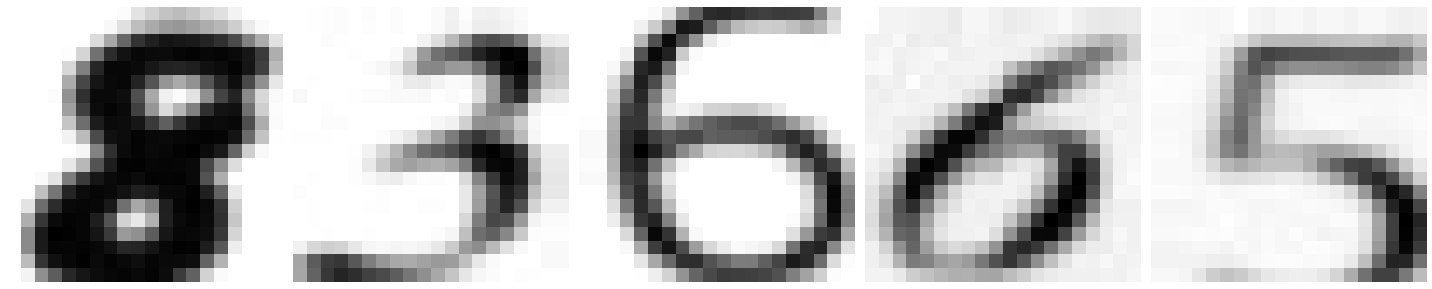

In [29]:
sample_training_images, _ = next(train_data_gen)
plot_images(sample_training_images[:5], IMG_WIDTH, IMG_HEIGHT)

# Our very simple model
A single convolution layer, followed by a dense layer followed by the output layer.
We're using linear regularisation and dropouts to prevent overfitting of the training data.

In [31]:
model = Sequential([
    Conv2D(16, 3, 
           padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(0.0001),
           input_shape=(IMG_HEIGHT, IMG_WIDTH , 1)),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(
        50,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.0001)
    ),
    Dropout(0.2),
    Dense(9, activation='softmax')
])


# Logging to tensorboard
We log the training stats along with the confusion matrix of the test data - should we be using the validation data for this?

In [32]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_confusion_matrix = create_confusion_matrix_callback(model, confusion_data_gen, log_dir)
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Show tensorboard inline

In [33]:
# launch tensorboard inline with the workbook
%tensorboard --logdir logs

# Do the actual training

In [34]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples // batch_size,
    callbacks=[tensorboard_callback, cm_callback]
)

Epoch 1/100
117/117 [==============================] - 5s 39ms/step - loss: 0.7734 - accuracy: 0.7567 - val_loss: 0.2148 - val_accuracy: 0.9364
Epoch 2/100
117/117 [==============================] - 5s 39ms/step - loss: 0.3092 - accuracy: 0.9129 - val_loss: 0.1304 - val_accuracy: 0.9623
Epoch 3/100
117/117 [==============================] - 5s 41ms/step - loss: 0.2444 - accuracy: 0.9284 - val_loss: 0.0860 - val_accuracy: 0.9774
Epoch 4/100
117/117 [==============================] - 4s 38ms/step - loss: 0.1955 - accuracy: 0.9482 - val_loss: 0.0783 - val_accuracy: 0.9784
Epoch 5/100
117/117 [==============================] - 5s 39ms/step - loss: 0.1734 - accuracy: 0.9530 - val_loss: 0.0684 - val_accuracy: 0.9838
Epoch 6/100
117/117 [==============================] - 4s 37ms/step - loss: 0.1524 - accuracy: 0.9610 - val_loss: 0.0745 - val_accuracy: 0.9752
Epoch 7/100
117/117 [==============================] - 5s 41ms/step - loss: 0.1387 - accuracy: 0.9671 - val_loss: 0.0889 - val_accuracy:

117/117 [==============================] - 4s 35ms/step - loss: 0.0626 - accuracy: 0.9880 - val_loss: 0.0490 - val_accuracy: 0.9935
Epoch 58/100
117/117 [==============================] - 4s 32ms/step - loss: 0.0590 - accuracy: 0.9915 - val_loss: 0.0509 - val_accuracy: 0.9925
Epoch 59/100
117/117 [==============================] - 4s 32ms/step - loss: 0.0568 - accuracy: 0.9907 - val_loss: 0.0431 - val_accuracy: 0.9935
Epoch 60/100
117/117 [==============================] - 4s 32ms/step - loss: 0.0603 - accuracy: 0.9899 - val_loss: 0.0523 - val_accuracy: 0.9925
Epoch 61/100
117/117 [==============================] - 4s 35ms/step - loss: 0.0684 - accuracy: 0.9872 - val_loss: 0.0434 - val_accuracy: 0.9946
Epoch 62/100
117/117 [==============================] - 4s 34ms/step - loss: 0.0599 - accuracy: 0.9882 - val_loss: 0.0389 - val_accuracy: 0.9968
Epoch 63/100
117/117 [==============================] - 4s 33ms/step - loss: 0.0518 - accuracy: 0.9939 - val_loss: 0.0377 - val_accuracy: 0.996

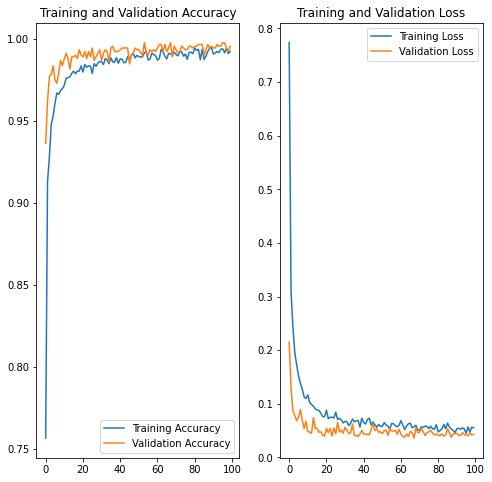

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
model.save("trained.model")

INFO:tensorflow:Assets written to: trained.model/assets


# Train on all the available data for our final model

In [37]:
all_data_gen = augmented_image_gen.flow_from_directory(batch_size=batch_size,
                                                     directory="all_data",
                                                     color_mode="grayscale",
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode="categorical")

Found 5193 images belonging to 9 classes.


In [38]:
all_history = model.fit_generator(
    all_data_gen,
    steps_per_epoch=train_data_gen.samples // batch_size,
    epochs=50)

Epoch 1/50
117/117 [==============================] - 4s 30ms/step - loss: 0.0611 - accuracy: 0.9901
Epoch 2/50
117/117 [==============================] - 4s 31ms/step - loss: 0.0682 - accuracy: 0.9884
Epoch 3/50
117/117 [==============================] - 4s 30ms/step - loss: 0.0553 - accuracy: 0.9922
Epoch 4/50
117/117 [==============================] - 3s 26ms/step - loss: 0.0581 - accuracy: 0.9898
Epoch 5/50
117/117 [==============================] - 3s 26ms/step - loss: 0.0531 - accuracy: 0.9941
Epoch 6/50
117/117 [==============================] - 3s 24ms/step - loss: 0.0574 - accuracy: 0.9906
Epoch 7/50
117/117 [==============================] - 3s 24ms/step - loss: 0.0598 - accuracy: 0.9887
Epoch 8/50
117/117 [==============================] - 3s 25ms/step - loss: 0.0540 - accuracy: 0.9923
Epoch 9/50
117/117 [==============================] - 3s 24ms/step - loss: 0.0495 - accuracy: 0.9936
Epoch 10/50
117/117 [==============================] - 3s 25ms/step - loss: 0.0612 - accura

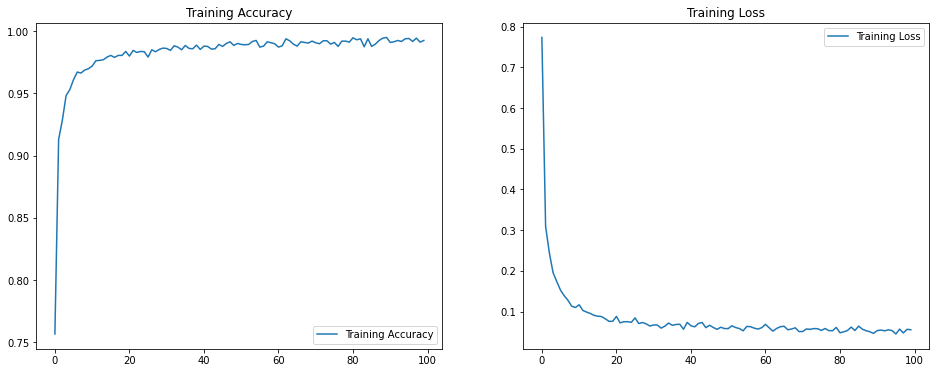

In [39]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [40]:
model.save("trained.model")

INFO:tensorflow:Assets written to: trained.model/assets


In [41]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model, "tfjs_model")

/Users/chrisgreening/Work/projects/sudoku-grab/tensorflow/venv/lib/python3.7/site-packages/tensorflowjs/converters/keras_h5_conversion.py:122: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)
